# 语言翻译

在此项目中，你将了解神经网络机器翻译这一领域。你将用由英语和法语语句组成的数据集，训练一个序列到序列模型（sequence to sequence model），该模型能够将新的英语句子翻译成法语。

## 获取数据

因为将整个英语语言内容翻译成法语需要大量训练时间，所以我们提供了一小部分的英语语料库。


In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)

## 探索数据

研究 view_sentence_range，查看并熟悉该数据的不同部分。


In [2]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

French sentences 0 to 10:
new jersey est parfois calme pendant l' automne 

## 实现预处理函数

### 文本到单词 id

和之前的 RNN 一样，你必须首先将文本转换为数字，这样计算机才能读懂。在函数 `text_to_ids()` 中，你需要将单词中的 `source_text` 和 `target_text` 转为 id。但是，你需要在 `target_text` 中每个句子的末尾，添加 `<EOS>` 单词 id。这样可以帮助神经网络预测句子应该在什么地方结束。


你可以通过以下代码获取  `<EOS> ` 单词ID：

```python
target_vocab_to_int['<EOS>']
```

你可以使用 `source_vocab_to_int` 和 `target_vocab_to_int` 获得其他单词 id。


In [3]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    # TODO: Implement Function
    sentences = source_text.split('\n')
    source_id_text = [[source_vocab_to_int[word] for word in sentence.split()] for sentence in sentences]
    sentences = target_text.split('\n')
    target_id_text = [[target_vocab_to_int[word] for word in (sentence+' <EOS>').split()] for sentence in sentences]
    return source_id_text, target_id_text

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### 预处理所有数据并保存

运行以下代码单元，预处理所有数据，并保存到文件中。


In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# 检查点

这是你的第一个检查点。如果你什么时候决定再回到该记事本，或需要重新启动该记事本，可以从这里继续。预处理的数据已保存到磁盘上。

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

# source_int_text 是一些句子的list，比如[[2, 54, 23 ...], [43, 3, 55...], ......]，target_int_text也一样
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### 检查 TensorFlow 版本，确认可访问 GPU

这一检查步骤，可以确保你使用的是正确版本的 TensorFlow，并且能够访问 GPU。


In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) in [LooseVersion('1.0.0'), LooseVersion('1.0.1')], 'This project requires TensorFlow version 1.0  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


## 构建神经网络

你将通过实现以下函数，构建出要构建一个序列到序列模型所需的组件：

- `model_inputs`
- `process_decoding_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### 输入

实现 `model_inputs()` 函数，为神经网络创建 TF 占位符。该函数应该创建以下占位符：

- 名为 “input” 的输入文本占位符，并使用 TF Placeholder 名称参数（等级（Rank）为 2）。
- 目标占位符（等级为 2）。
- 学习速率占位符（等级为 0）。
- 名为 “keep_prob” 的保留率占位符，并使用 TF Placeholder 名称参数（等级为 0）。

在以下元祖（tuple）中返回占位符：（输入、目标、学习速率、保留率）


In [7]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate, keep probability)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.int32, shape=(None, None), name='input')
    output = tf.placeholder(tf.int32, shape=(None, None), name='output')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, shape=None, name='keep_prob')
    return input, output, learning_rate, keep_prob

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 处理解码输入

使用 TensorFlow 实现 `process_decoding_input`，以便删掉 `target_data` 中每个批次的最后一个单词 ID，并将 GO ID 放到每个批次的开头。

In [8]:
# 训练时，在序列的解码部分，将正确的word（来自target）作为模型的输入序列，而不是用model预测的word作为输入
def process_decoding_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for dencoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    # TODO: Implement Function
    go_array = tf.fill((batch_size,1), target_vocab_to_int['<GO>'])
#    print(go_array)
    target_data = tf.concat([go_array, target_data], 1)
#    print(target_data)
#    target_data = tf.slice(target_data, [0,0], [batch_size, -1])
    target_data = target_data[:,0:-1]
#    print(target_data)
    return target_data

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_decoding_input(process_decoding_input)

Tests Passed


### 编码

实现 `encoding_layer()`，以使用 [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) 创建编码器 RNN 层级。

In [9]:
# 序列到序列模型的编码部分的LSTM
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :return: RNN state
    """
    # TODO: Implement Function
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_size)
    cells = tf.contrib.rnn.MultiRNNCell(num_layers * [cell])
#    initial_state = cells.zero_state(batch_size, tf.float32)
    outputs, state = tf.nn.dynamic_rnn(cells, rnn_inputs, dtype=tf.float32)
#    final_state = tf.identity(final_state, name='final_state')
    return state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### 解码 - 训练

使用 [`tf.contrib.seq2seq.simple_decoder_fn_train()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_train) 和 [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) 创建训练分对数（training logits）。将 `output_fn` 应用到 [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) 输出上。

In [10]:
# 模型解码部分，训练时（inference）的输出
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope,
                         output_fn, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param sequence_length: Sequence Length
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Train Logits
    """
    # TODO: Implement Function
    dynamic_fn_train = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    outputs_train, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, dynamic_fn_train, inputs=dec_embed_input, sequence_length=sequence_length, scope=decoding_scope)
#    print('outputs_train.get_shape()', outputs_train.get_shape())
    outputs_train = tf.nn.dropout(outputs_train, keep_prob)
    outputs_train = output_fn(outputs_train)
#    print('outputs_train.get_shape()', outputs_train.get_shape())
    return outputs_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### 解码 - 推论

使用 [`tf.contrib.seq2seq.simple_decoder_fn_inference()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_inference) 和 [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) 创建推论分对数（inference logits）。

In [11]:
# 模型解码部分，预测时（inference）的输出。预测阶段keep_prob应无必要。
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param maximum_length: The maximum allowed time steps to decode
    :param vocab_size: Size of vocabulary
    :param decoding_scope: TensorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Inference Logits
    """
    # TODO: Implement Function
    dynamic_fn_infer = tf.contrib.seq2seq.simple_decoder_fn_inference(output_fn, encoder_state, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size)
    outputs_infer, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, dynamic_fn_infer, scope=decoding_scope)
#    print('outputs_infer.get_shape()', outputs_infer.get_shape())
#    outputs_infer = tf.nn.dropout(outputs_infer, keep_prob)
#    print('outputs_infer.get_shape()', outputs_infer.get_shape())
#    outputs_infer = output_fn(outputs_infer)
#    print('outputs_infer.get_shape()', outputs_infer.get_shape())
    return outputs_infer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### 构建解码层级

实现 `decoding_layer()` 以创建解码器 RNN 层级。

- 使用 `rnn_size` 和 `num_layers` 创建解码 RNN 单元。
- 使用 [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) 创建输出函数，将输入，也就是分对数转换为类分对数（class logits）。
- 使用 `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope, output_fn, keep_prob)` 函数获取训练分对数。
- 使用 `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size, decoding_scope, output_fn, keep_prob)` 函数获取推论分对数。

注意：你将需要使用 [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 在训练和推论分对数间分享变量。

In [12]:
# 模型的解码部分。包括训练时解码和预测时解码的输出
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size,
                   num_layers, target_vocab_to_int, keep_prob):
    """
    Create decoding layer
    :param dec_embed_input: Decoder embedded input。已经经过embedding矩阵转换后的编码，shape=(batch_size, sequence_length, embedding_size)
    :param dec_embeddings: Decoder embeddings。embedding转换矩阵，shape=(vocab_size, embedding_size)
    :param encoder_state: The encoded state
    :param vocab_size: Size of vocabulary
    :param sequence_length: Sequence Length
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param keep_prob: Dropout keep probability
    :return: Tuple of (Training Logits, Inference Logits)
    """
    # TODO: Implement Function
    with tf.variable_scope("decoding") as decoding_scope:
        # 模型解码部分的LSTM
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_size)
        cells = tf.contrib.rnn.MultiRNNCell(num_layers * [cell])
    #    outputs, state = tf.nn.dynamic_rnn(cells, dec_embed_output, dtype=tf.float32)
    
        # LSTM输出接入全连接层（rnn_size向量转换为vocab_size向量）
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)
        
        # 模型解码部分，训练时的输出序列（用target作为输入）
        outputs_train = decoding_layer_train(encoder_state, cells, dec_embed_input, sequence_length, decoding_scope,
                                             output_fn, keep_prob)
        # 
        decoding_scope.reuse_variables()
        # 模型解码部分，预测时(inference)的输出序列（用上一个时间步的输出作为输入）
        outputs_infer = decoding_layer_infer(encoder_state, cells, dec_embeddings, 
                                             target_vocab_to_int['<GO>'], target_vocab_to_int['<EOS>'],
                                             sequence_length, vocab_size, decoding_scope, output_fn, keep_prob)
    return outputs_train, outputs_infer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer(decoding_layer)

Tests Passed


### 构建神经网络

应用你在上方实现的函数，以：

- 向编码器的输入数据应用嵌入。
- 使用 `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)` 编码输入。
- 使用 `process_decoding_input(target_data, target_vocab_to_int, batch_size)` 函数处理目标数据。
- 向解码器的目标数据应用嵌入。
- 使用 `decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)` 解码编码的输入数据。

In [13]:
# 序列到序列模型
def seq2seq_model(input_data, target_data, keep_prob, batch_size, sequence_length, source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder。shape=(batch_size, sequence_length)
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param sequence_length: Sequence Length
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training Logits, Inference Logits)
    """
    # TODO: Implement Function
    # 编码部分和解码部分的embedding转换矩阵
    embedding_enc = tf.Variable(tf.truncated_normal(shape=[source_vocab_size, enc_embedding_size], mean=0, stddev=1)) # create embedding weight matrix here
    embedding_dec = tf.Variable(tf.truncated_normal(shape=[target_vocab_size, dec_embedding_size], mean=0, stddev=1)) # create embedding weight matrix here

    # input_data进行embed编码
    input_data_embed = tf.nn.embedding_lookup(embedding_enc, input_data)

    # 模型的编码部分（处理输入序列）
    encoder_state = encoding_layer(input_data_embed, rnn_size, num_layers, keep_prob)
    
    # 模型的解码部分，先将target_data转换成解码部分的输入
    dec_input = process_decoding_input(target_data, target_vocab_to_int, batch_size)
    # dec_input进行embed编码
    dec_embed_input = tf.nn.embedding_lookup(embedding_dec, dec_input)
    
    # 模型的解码部分（处理输出序列）
    outputs_train, outputs_infer = decoding_layer(dec_embed_input, embedding_dec, encoder_state, 
            target_vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)
    
    return outputs_train, outputs_infer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_seq2seq_model(seq2seq_model)

Tests Passed


## 训练神经网络

### 超参数

调试以下参数：

- 将 `epochs` 设为 epoch 次数。
- 将 `batch_size` 设为批次大小。
- 将 `rnn_size` 设为 RNN 的大小。
- 将 `num_layers` 设为层级数量。
- 将 `encoding_embedding_size` 设为编码器嵌入大小。
- 将 `decoding_embedding_size` 设为解码器嵌入大小
- 将 `learning_rate` 设为训练速率。
- 将 `keep_probability` 设为丢弃保留率（Dropout keep probability）。

In [14]:
# Number of Epochs
epochs = 10
# Batch Size
batch_size = 1024
# RNN Size
rnn_size = 64
# Number of Layers
num_layers = 3
# Embedding Size
encoding_embedding_size = 200
decoding_embedding_size = 200
# Learning Rate
learning_rate = 0.02
# Dropout Keep Probability
keep_probability = 0.6

### 构建图表

使用你实现的神经网络构建图表。

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_source_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob = model_inputs()
    sequence_length = tf.placeholder_with_default(max_source_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)
    
    train_logits, inference_logits = seq2seq_model(
        tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, sequence_length, len(source_vocab_to_int), len(target_vocab_to_int),
        encoding_embedding_size, decoding_embedding_size, rnn_size, num_layers, target_vocab_to_int)

    tf.identity(inference_logits, 'logits')
    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

### 训练

利用预处理的数据训练神经网络。如果很难获得低损失值，请访问我们的论坛，看看其他人是否遇到了相同的问题。

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import time

num_batches_to_print = 20
num_batches_to_list = 1
train_acc_list = list()
valid_acc_list = list()
train_loss_list = list()

def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1]), (0,0)],
            'constant')

    return np.mean(np.equal(target, np.argmax(logits, 2)))

train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]

valid_source = helper.pad_sentence_batch(source_int_text[:batch_size])
valid_target = helper.pad_sentence_batch(target_int_text[:batch_size])

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch) in enumerate(
                helper.batch_data(train_source, train_target, batch_size)):
            start_time = time.time()
            
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 sequence_length: target_batch.shape[1],
                 keep_prob: keep_probability})
            
            batch_train_logits = sess.run(
                inference_logits,
                {input_data: source_batch, keep_prob: 1.0})
            batch_valid_logits = sess.run(
                inference_logits,
                {input_data: valid_source, keep_prob: 1.0})
                
            train_acc = get_accuracy(target_batch, batch_train_logits)
            valid_acc = get_accuracy(np.array(valid_target), batch_valid_logits)
            end_time = time.time()
            
            # 记录loss和acc
            if batch_i % num_batches_to_list == 0:
                train_acc_list.append(train_acc)
                valid_acc_list.append(valid_acc)
                train_loss_list.append(loss)
            if batch_i % num_batches_to_print == 0:
                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.3f}, Validation Accuracy: {:>6.3f}, Loss: {:>6.3f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch    0/134 - Train Accuracy:  0.297, Validation Accuracy:  0.339, Loss:  5.873
Epoch   0 Batch   20/134 - Train Accuracy:  0.368, Validation Accuracy:  0.371, Loss:  2.663
Epoch   0 Batch   40/134 - Train Accuracy:  0.438, Validation Accuracy:  0.464, Loss:  2.182
Epoch   0 Batch   60/134 - Train Accuracy:  0.431, Validation Accuracy:  0.463, Loss:  1.838
Epoch   0 Batch   80/134 - Train Accuracy:  0.453, Validation Accuracy:  0.482, Loss:  1.582
Epoch   0 Batch  100/134 - Train Accuracy:  0.484, Validation Accuracy:  0.507, Loss:  1.312
Epoch   0 Batch  120/134 - Train Accuracy:  0.512, Validation Accuracy:  0.534, Loss:  1.081
Epoch   1 Batch    0/134 - Train Accuracy:  0.570, Validation Accuracy:  0.589, Loss:  0.962
Epoch   1 Batch   20/134 - Train Accuracy:  0.630, Validation Accuracy:  0.634, Loss:  0.798
Epoch   1 Batch   40/134 - Train Accuracy:  0.646, Validation Accuracy:  0.648, Loss:  0.737
Epoch   1 Batch   60/134 - Train Accuracy:  0.659, Validation Accuracy

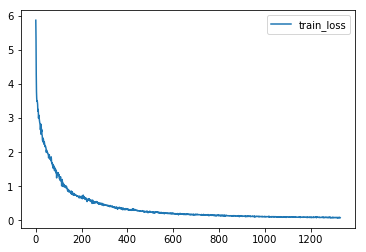

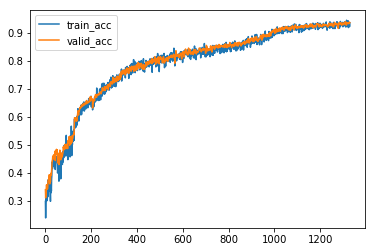

In [17]:
# 打印loss和acc
import matplotlib.pyplot as plt
batch_number = list(range(len(train_acc_list)))
plt.plot(batch_number, train_loss_list, label='train_loss')
plt.legend()
plt.show()
plt.plot(batch_number, train_acc_list, label='train_acc')
plt.plot(batch_number, valid_acc_list, label='valid_acc')
plt.legend()
plt.show()

### 保存参数

保存 `batch_size` 和 `save_path` 参数以进行推论（for inference）。

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path)

# 检查点

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## 句子到序列

要向模型提供要翻译的句子，你首先需要预处理该句子。实现函数 `sentence_to_seq()` 以预处理新的句子。

- 将句子转换为小写形式
- 使用 `vocab_to_int` 将单词转换为 id
 - 如果单词不在词汇表中，将其转换为`<UNK>` 单词 id

In [20]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    # TODO: Implement Function
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in sentence.lower().split()]

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## 翻译

将 `translate_sentence` 从英语翻译成法语。

In [21]:
translate_sentence = 'he saw a old yellow truck .'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence], keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

Input
  Word Ids:      [47, 91, 165, 8, 152, 160, 169]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [91, 328, 92, 160, 178, 349, 307, 330, 1]
  French Words: ['il', 'a', 'vu', 'un', 'camion', 'rouge', 'brillant', '.', '<EOS>']


## 不完美的翻译

你可能注意到了，某些句子的翻译质量比其他的要好。因为你使用的数据集只有 227 个英语单词，但实际生活中有数千个单词，只有使用这些单词的句子结果才会比较理想。对于此项目，不需要达到完美的翻译。但是，如果你想创建更好的翻译模型，则需要更好的数据。

你可以使用 [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar) 语料库训练模型。该数据集拥有更多的词汇，讨论的话题也更丰富。但是，训练时间要好多天的时间，所以确保你有 GPU 并且对于我们提供的数据集，你的神经网络性能很棒。提交此项目后，别忘了研究下 WMT10 语料库。


## 提交项目

提交项目时，确保先运行所有单元，然后再保存记事本。保存记事本文件为 “dlnd_language_translation.ipynb”，再通过菜单中的“文件” ->“下载为”将其另存为 HTML 格式。提交的项目文档中需包含“helper.py”和“problem_unittests.py”文件。
